In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
from sklearn.inspection import DecisionBoundaryDisplay
import warnings
warnings.filterwarnings('ignore')


# 1. ЗАГРУЗКА И ПРЕДОБРАБОТКА

df = pd.read_csv('weather.csv')

# Переименование колонок для удобства
df = df.rename(columns={
    'Date/Time': 'datetime',
    'Temp_C': 'temp',
    'Dew Point Temp_C': 'dew_point',
    'Rel Hum_%': 'humidity',
    'Wind Speed_km/h': 'wind_speed',
    'Visibility_km': 'visibility',
    'Press_kPa': 'pressure',
    'Weather': 'weather'
})


# Создание бинарной целевой переменной: осадки (любые)
precipitation_keywords = [
    'Rain', 'Drizzle', 'Snow', 'Sleet', 'Hail', 'Thunderstorm',
    'Freezing Rain', 'Ice Pellets', 'Showers'
]
pattern = r'\b(?:' + '|'.join(precipitation_keywords) + r')\b'
df['precipitation'] = df['weather'].str.contains(pattern, case=False, na=False).astype(int)

# Удаление исходных колонок
df = df.drop(columns=['weather', 'datetime'])

# Проверка пропусков и импутация
print("Пропущенные значения:")
print(df.isnull().sum())
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Целевая переменная и признаки
y = df_imputed['precipitation'].astype(int)
feature_cols = ['temp', 'humidity', 'pressure', 'wind_speed', 'dew_point', 'visibility']
X = df_imputed[feature_cols]

print(f"\nБаланс классов (осадки):\n{y.value_counts(normalize=True)}")

Пропущенные значения:
temp             0
dew_point        0
humidity         0
wind_speed       0
visibility       0
pressure         0
precipitation    0
dtype: int64

Баланс классов (осадки):
precipitation
0    0.842555
1    0.157445
Name: proportion, dtype: float64


In [37]:
# БАЗОВАЯ ИНФОРМАЦИЯ О ДАННЫХ 
print("Размер датасета:", df.shape)
print("\nОбщая информация о данных:")
print(df.info())
print("\nБазовая статистика числовых признаков:")
print(df.describe().round(2))

Размер датасета: (8784, 7)

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp           8784 non-null   float64
 1   dew_point      8784 non-null   float64
 2   humidity       8784 non-null   int64  
 3   wind_speed     8784 non-null   int64  
 4   visibility     8784 non-null   float64
 5   pressure       8784 non-null   float64
 6   precipitation  8784 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 480.5 KB
None

Базовая статистика числовых признаков:
          temp  dew_point  humidity  wind_speed  visibility  pressure  \
count  8784.00    8784.00   8784.00     8784.00     8784.00   8784.00   
mean      8.80       2.56     67.43       14.95       27.66    101.05   
std      11.69      10.88     16.92        8.69       12.62      0.84   
min     -23.30     -28.50     18.00        0.00       

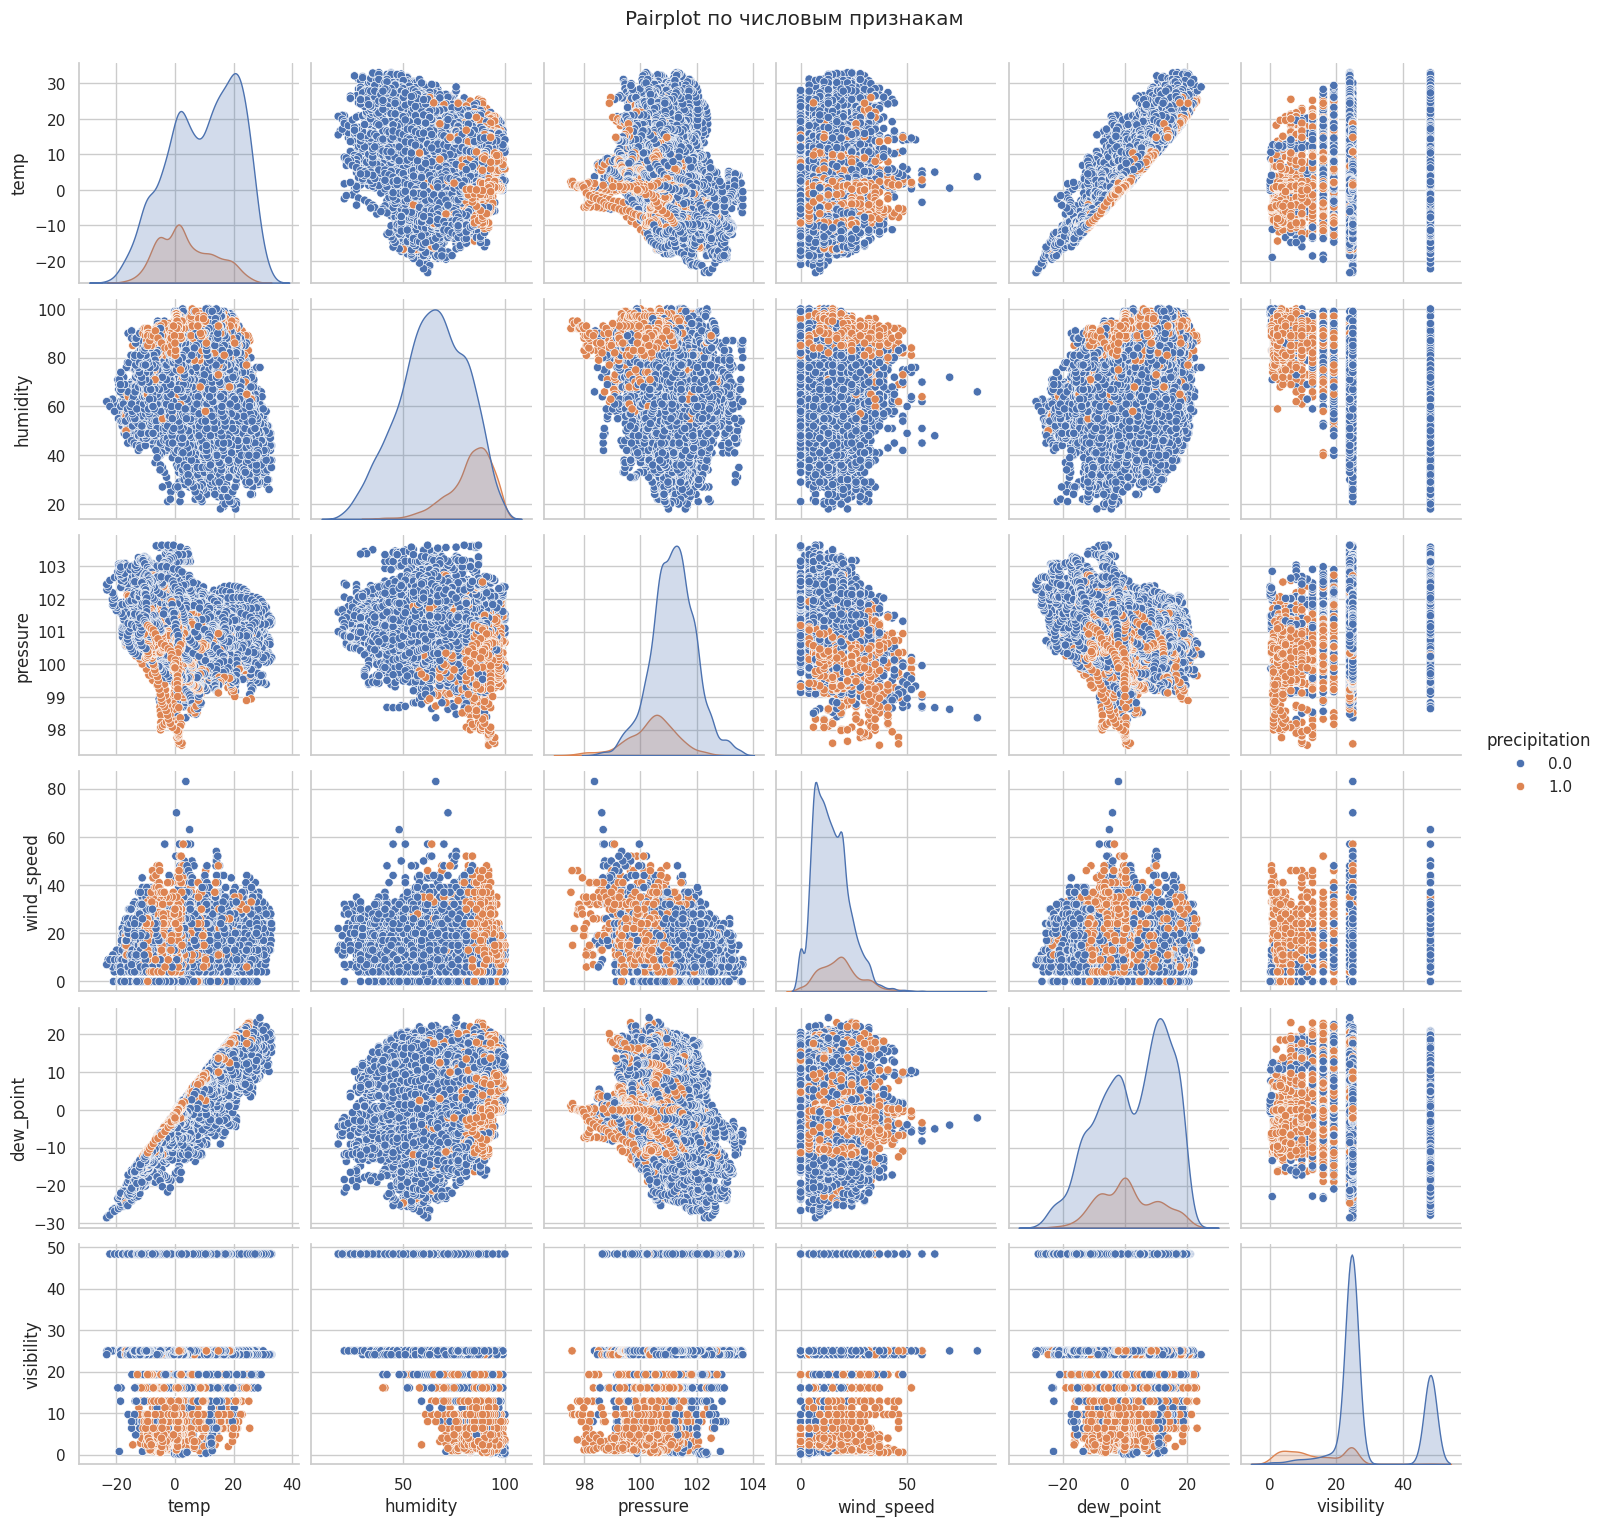

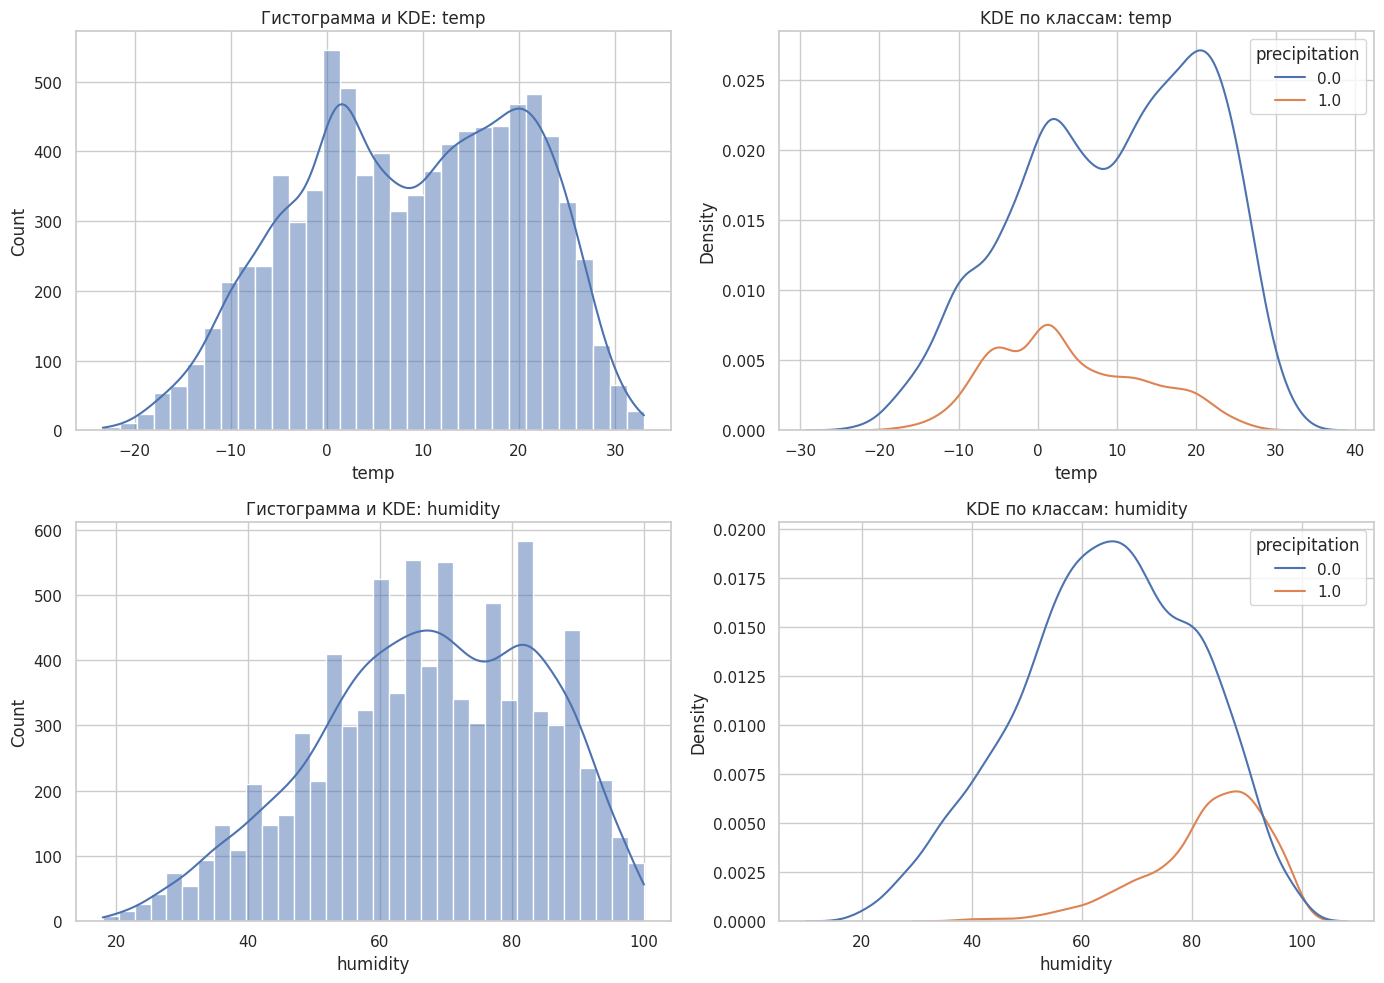

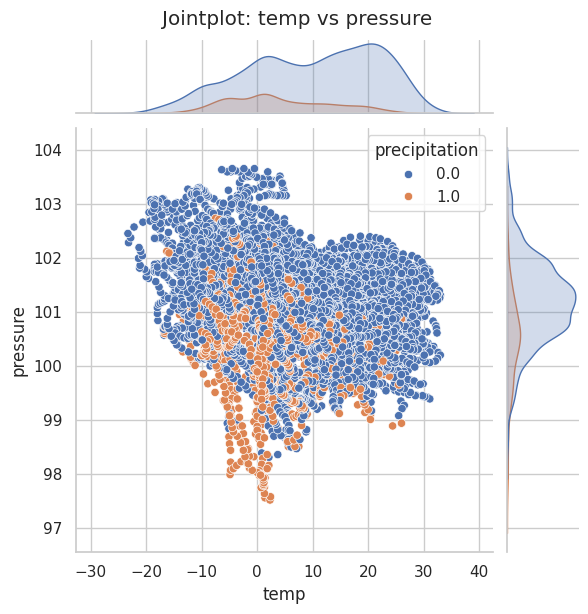

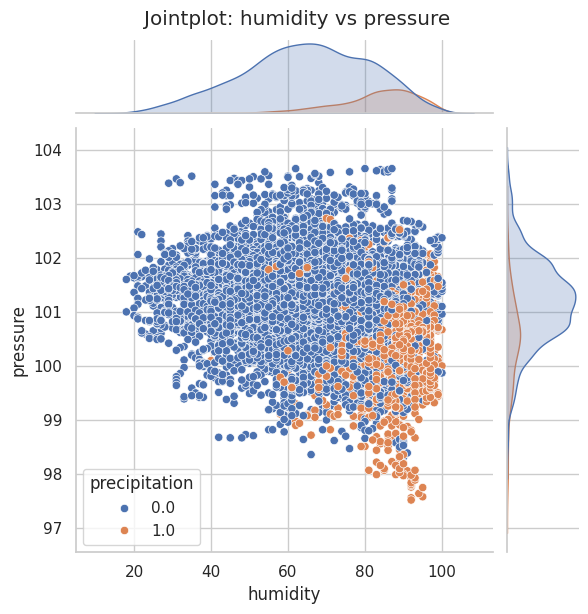

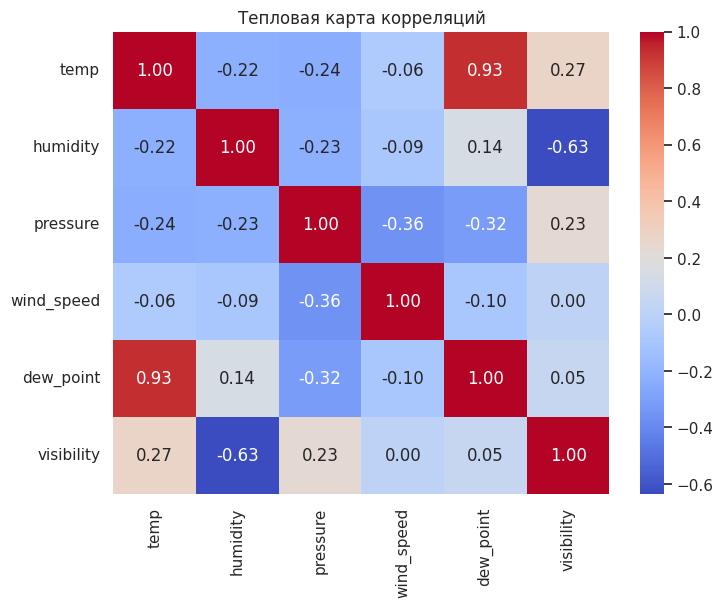

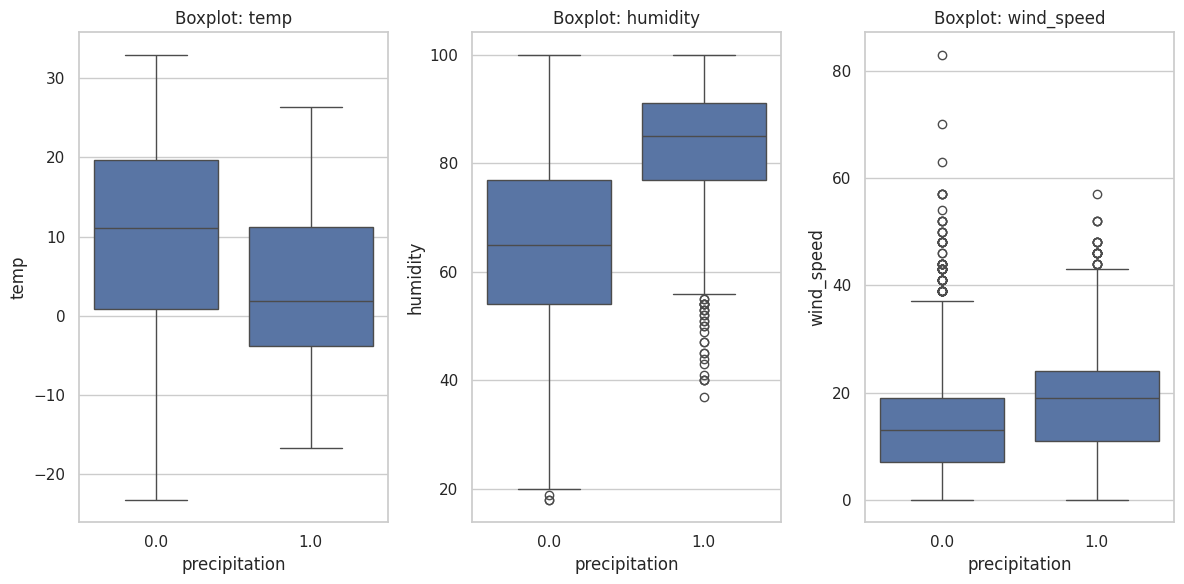

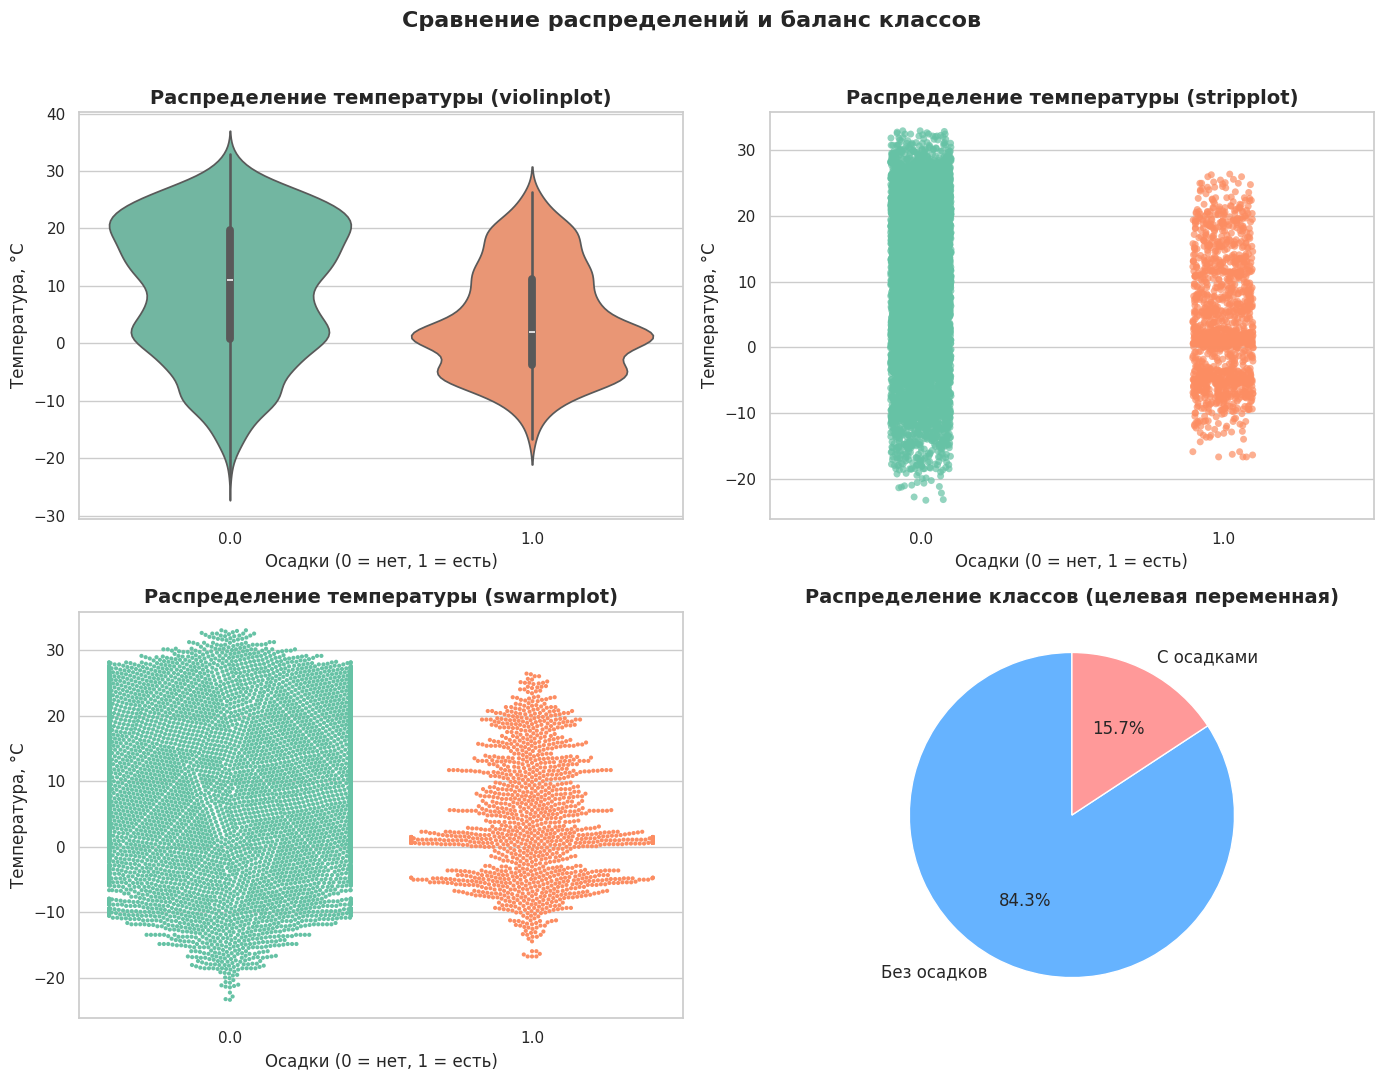

In [41]:
# 2. ВИЗУАЛИЗАЦИЯ

sns.set(style="whitegrid")

# Pairplot
sns.pairplot(df_imputed[feature_cols + ['precipitation']], hue='precipitation', diag_kind='kde')
plt.suptitle('Pairplot по числовым признакам', y=1.02)
plt.show()

# Гистограммы и KDE для двух признаков
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, col in enumerate(['temp', 'humidity']):
    # Гистограмма с KDE
    sns.histplot(df_imputed[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Гистограмма и KDE: {col}')
    # KDE по классам
    sns.kdeplot(data=df_imputed, x=col, hue='precipitation', ax=axes[i, 1])
    axes[i, 1].set_title(f'KDE по классам: {col}')
plt.tight_layout()
plt.show()

# Jointplots — отдельно
for col in ['temp', 'humidity']:
    sns.jointplot(data=df_imputed, x=col, y='pressure', hue='precipitation', kind='scatter')
    plt.suptitle(f'Jointplot: {col} vs pressure', y=1.02)
plt.show()

# Тепловая карта корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(df_imputed[feature_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляций')
plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
for i, col in enumerate(['temp', 'humidity', 'wind_speed'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df_imputed, x='precipitation', y=col)
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

# Визуализация статистик: violinplot, stripplot, swarmplot, pie
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# 1. Violinplot
sns.violinplot(data=df_imputed, x='precipitation', y='temp', ax=axes[0, 0], palette="Set2")
axes[0, 0].set_title('Распределение температуры (violinplot)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Осадки (0 = нет, 1 = есть)', fontsize=12)
axes[0, 0].set_ylabel('Температура, °C', fontsize=12)

# 2. Stripplot
sns.stripplot(data=df_imputed, x='precipitation', y='temp', jitter=True, ax=axes[0, 1], palette="Set2", alpha=0.7)
axes[0, 1].set_title('Распределение температуры (stripplot)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Осадки (0 = нет, 1 = есть)', fontsize=12)
axes[0, 1].set_ylabel('Температура, °C', fontsize=12)

# 3. Swarmplot
sns.swarmplot(data=df_imputed, x='precipitation', y='temp', ax=axes[1, 0], palette="Set2", size=3)
axes[1, 0].set_title('Распределение температуры (swarmplot)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Осадки (0 = нет, 1 = есть)', fontsize=12)
axes[1, 0].set_ylabel('Температура, °C', fontsize=12)

# 4. Pie chart
precip_counts = df_imputed['precipitation'].value_counts()
axes[1, 1].pie(
    precip_counts,
    labels=['Без осадков', 'С осадками'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    textprops={'fontsize': 12}
)
axes[1, 1].set_title('Распределение классов (целевая переменная)', fontsize=14, fontweight='bold')

# Общее оформление
plt.suptitle('Сравнение распределений и баланс классов', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Оставляем место под общий заголовок
plt.show()

In [22]:
# 3. ОБНАРУЖЕНИЕ ВЫБРОСОВ ПО КАЖДОМУ ПРИЗНАКУ ОТДЕЛЬНО

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

# Методы (без OneClassSVM random_state — он не поддерживается)
outlier_methods = {
    'IQR': lambda x: (x < (x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)))) |
                     (x > (x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25)))),
    'IsolationForest': lambda x: IsolationForest(contamination=0.05, random_state=42).fit_predict(x.values.reshape(-1, 1)) == -1,
    'LOF': lambda x: LocalOutlierFactor(contamination=0.05, n_neighbors=20).fit_predict(x.values.reshape(-1, 1)) == -1,
    'EllipticEnvelope': lambda x: EllipticEnvelope(contamination=0.05, random_state=42).fit_predict(x.values.reshape(-1, 1)) == -1,
    'OneClassSVM': lambda x: OneClassSVM(nu=0.05, kernel="rbf", gamma="scale").fit_predict(x.values.reshape(-1, 1)) == -1,
}

# Выбираем признаки для анализа
features_to_check = ['temp', 'humidity', 'visibility', 'pressure', 'wind_speed', 'dew_point']

for feature in features_to_check:
    print(f"\nДоля выбросов по методам (признак: '{feature}'):")
    for name, method in outlier_methods.items():
        outliers = method(df_imputed[feature])
        print(f"{name:18}: {outliers.mean():6.2%}")


Доля выбросов по методам (признак: 'temp'):
IQR               :  0.00%
IsolationForest   :  5.00%
LOF               :  4.34%
EllipticEnvelope  :  4.92%
OneClassSVM       :  4.72%

Доля выбросов по методам (признак: 'humidity'):
IQR               :  0.02%
IsolationForest   :  4.99%
LOF               :  0.43%
EllipticEnvelope  :  4.79%
OneClassSVM       :  8.65%

Доля выбросов по методам (признак: 'visibility'):
IQR               : 40.29%
IsolationForest   :  4.71%
LOF               :  0.55%
EllipticEnvelope  :  0.51%
OneClassSVM       : 61.89%

Доля выбросов по методам (признак: 'pressure'):
IQR               :  2.36%
IsolationForest   :  4.96%
LOF               :  4.97%
EllipticEnvelope  :  4.99%
OneClassSVM       : 13.39%

Доля выбросов по методам (признак: 'wind_speed'):
IQR               :  1.84%
IsolationForest   :  2.45%
LOF               :  0.38%
EllipticEnvelope  :  6.83%
OneClassSVM       : 15.97%

Доля выбросов по методам (признак: 'dew_point'):
IQR               :  0.00%
Iso

In [24]:
# Сколько всего значений >= 48.3 по visibility?
high_vis = df_imputed[df_imputed['visibility'] >= 48.3]
print(f"Значений ≥48.3 км: {len(high_vis)} из {len(df_imputed)} ({len(high_vis)/len(df_imputed):.1%})")

# Посмотрим, при каких погодных условиях это бывает
print("\nПримеры условий при visibility = 48.3:")
sample = df_imputed[df_imputed['visibility'] == 48.3].sample(5)
print(sample[['temp', 'humidity', 'pressure', 'precipitation']])

Значений ≥48.3 км: 2014 из 8784 (22.9%)

Примеры условий при visibility = 48.3:
      temp  humidity  pressure  precipitation
2797  10.3      52.0    100.24            0.0
3039  16.6      26.0    101.61            0.0
5913  21.1      55.0    101.65            0.0
1576  -4.9      41.0    102.94            0.0
4355  26.3      50.0     99.79            0.0


In [19]:
Q1 = df_imputed['temp'].quantile(0.25)
Q3 = df_imputed['temp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Диапазон IQR для temp: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Мин/Макс temp: {df_imputed['temp'].min():.2f} / {df_imputed['temp'].max():.2f}")
print()

Q1 = df_imputed['humidity'].quantile(0.25)
Q3 = df_imputed['humidity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Диапазон IQR для humidity: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Мин/Макс temp: {df_imputed['humidity'].min():.2f} / {df_imputed['humidity'].max():.2f}")
print()

Q1 = df_imputed['visibility'].quantile(0.25)
Q3 = df_imputed['visibility'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Диапазон IQR для visibility: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Мин/Макс temp: {df_imputed['visibility'].min():.2f} / {df_imputed['visibility'].max():.2f}")



Диапазон IQR для temp: [-27.95, 46.85]
Мин/Макс temp: -23.30 / 33.00

Диапазон IQR для humidity: [18.50, 118.50]
Мин/Макс temp: 18.00 / 100.00

Диапазон IQR для visibility: [22.75, 26.35]
Мин/Макс temp: 0.20 / 48.30


In [25]:
# 4. БАЛАНСИРОВКА КЛАССОВ И ПОДГОТОВКА ДАННЫХ

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_bal_scaled = scaler.transform(X_test)

In [26]:
# 5. ОБУЧЕНИЕ МОДЕЛЕЙ С GridSearchCV

models = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200], 'max_depth': [5, 10, None]}),
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
        'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}),
    'XGBoost': (XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False), {
        'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}),
    'SVC': (SVC(probability=True, random_state=42), {
        'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']})
}

results = {}

for name, (model, params) in models.items():
    print(f"\nОбучение {name}...")

    if name in ['LogisticRegression', 'SVC']:
        grid = GridSearchCV(model, params, cv=3, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model_orig = grid.best_estimator_
        y_pred_orig = best_model_orig.predict_proba(X_test_scaled)[:, 1]

        grid_bal = GridSearchCV(clone(model), params, cv=3, scoring='roc_auc', n_jobs=-1)
        grid_bal.fit(X_train_bal_scaled, y_train_bal)
        best_model_bal = grid_bal.best_estimator_
        y_pred_bal = best_model_bal.predict_proba(X_test_bal_scaled)[:, 1]
    else:
        grid = GridSearchCV(model, params, cv=3, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model_orig = grid.best_estimator_
        y_pred_orig = best_model_orig.predict_proba(X_test)[:, 1]

        grid_bal = GridSearchCV(clone(model), params, cv=3, scoring='roc_auc', n_jobs=-1)
        grid_bal.fit(X_train_bal, y_train_bal)
        best_model_bal = grid_bal.best_estimator_
        y_pred_bal = best_model_bal.predict_proba(X_test)[:, 1]

    auc_orig = roc_auc_score(y_test, y_pred_orig)
    auc_bal = roc_auc_score(y_test, y_pred_bal)

    results[name] = {
        'orig': (best_model_orig, y_pred_orig, auc_orig),
        'bal': (best_model_bal, y_pred_bal, auc_bal)
    }
    print(f"{name} — AUC (ориг): {auc_orig:.4f}, AUC (баланс): {auc_bal:.4f}")


Обучение RandomForest...
RandomForest — AUC (ориг): 0.9371, AUC (баланс): 0.9324

Обучение LogisticRegression...
LogisticRegression — AUC (ориг): 0.9210, AUC (баланс): 0.9195

Обучение XGBoost...
XGBoost — AUC (ориг): 0.9315, AUC (баланс): 0.9267

Обучение SVC...
SVC — AUC (ориг): 0.9172, AUC (баланс): 0.9160


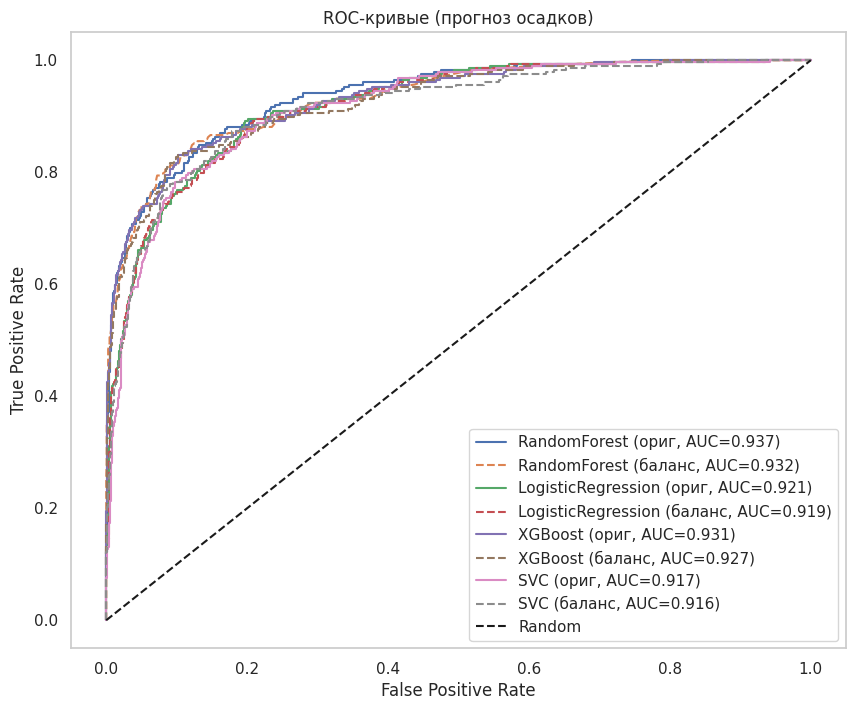

In [27]:
# 6. ROC-АНАЛИЗ

plt.figure(figsize=(10, 8))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['orig'][1])
    plt.plot(fpr, tpr, label=f"{name} (ориг, AUC={res['orig'][2]:.3f})")
    fpr, tpr, _ = roc_curve(y_test, res['bal'][1])
    plt.plot(fpr, tpr, linestyle='--', label=f"{name} (баланс, AUC={res['bal'][2]:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые (прогноз осадков)')
plt.legend()
plt.grid()
plt.show()

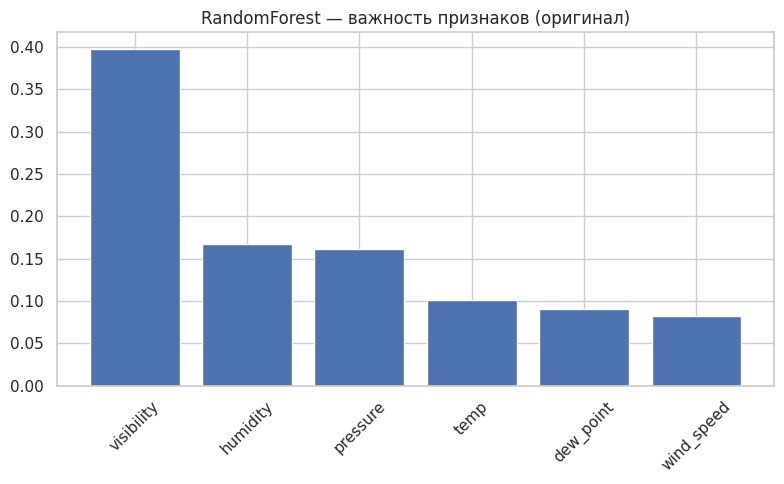

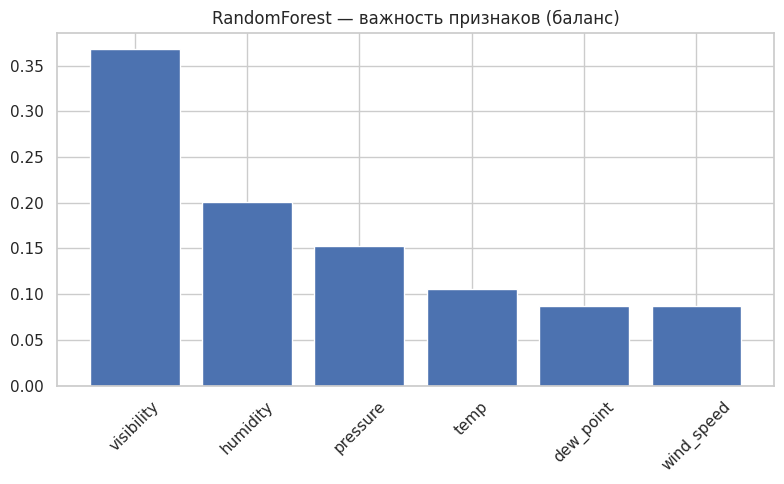

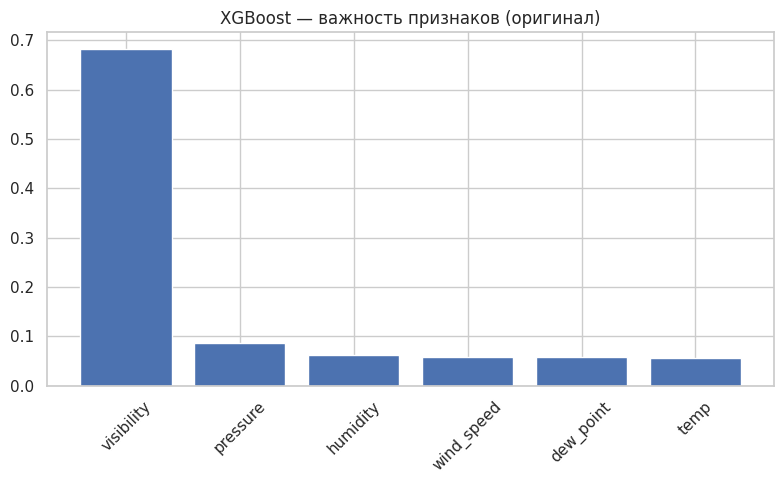

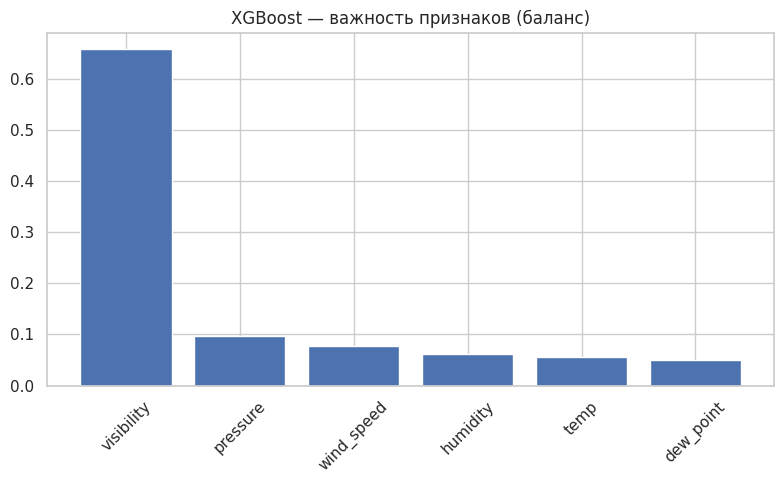

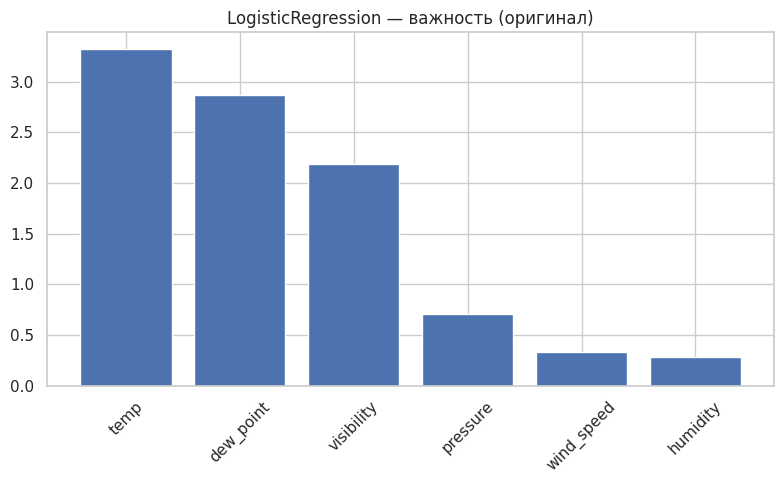

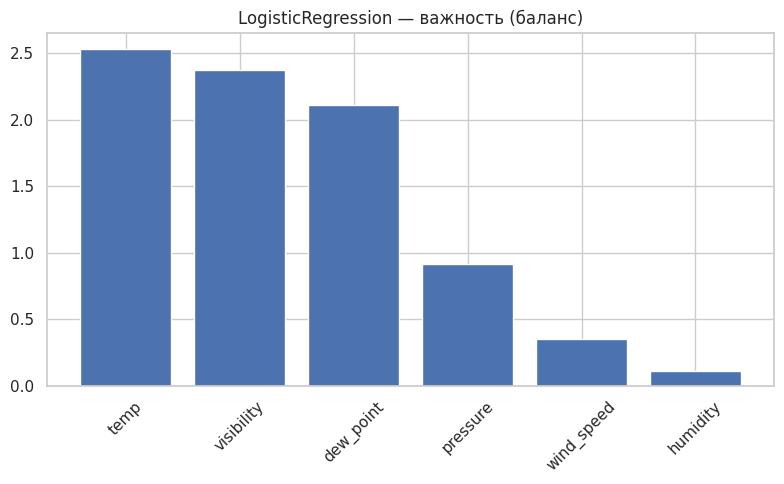

In [28]:
# 7. ВАЖНОСТЬ ПРИЗНАКОВ

def plot_feature_importance(model, features, title):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        return
    indices = np.argsort(importance)[::-1]
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), [features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

for name in ['RandomForest', 'XGBoost']:
    plot_feature_importance(results[name]['orig'][0], feature_cols, f'{name} — важность признаков (оригинал)')
    plot_feature_importance(results[name]['bal'][0], feature_cols, f'{name} — важность признаков (баланс)')

plot_feature_importance(results['LogisticRegression']['orig'][0], feature_cols, 'LogisticRegression — важность (оригинал)')
plot_feature_importance(results['LogisticRegression']['bal'][0], feature_cols, 'LogisticRegression — важность (баланс)')

In [29]:
# 8. K-FOLD КРОСС-ВАЛИДАЦИЯ

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, res in results.items():
    model_orig = res['orig'][0]
    model_bal = res['bal'][0]

    if name in ['LogisticRegression', 'SVC']:
        scores_orig = cross_val_score(model_orig, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
        scores_bal = cross_val_score(model_bal, X_train_bal_scaled, y_train_bal, cv=cv, scoring='roc_auc')
    else:
        scores_orig = cross_val_score(model_orig, X_train, y_train, cv=cv, scoring='roc_auc')
        scores_bal = cross_val_score(model_bal, X_train_bal, y_train_bal, cv=cv, scoring='roc_auc')

    cv_results[name] = {
        'orig': (scores_orig.mean(), scores_orig.std()),
        'bal': (scores_bal.mean(), scores_bal.std())
    }
    print(f"{name} — CV AUC (ориг): {scores_orig.mean():.4f} ± {scores_orig.std():.4f}")
    print(f"{name} — CV AUC (баланс): {scores_bal.mean():.4f} ± {scores_bal.std():.4f}")

RandomForest — CV AUC (ориг): 0.9351 ± 0.0077
RandomForest — CV AUC (баланс): 0.9873 ± 0.0015
LogisticRegression — CV AUC (ориг): 0.9219 ± 0.0064
LogisticRegression — CV AUC (баланс): 0.9256 ± 0.0023
XGBoost — CV AUC (ориг): 0.9335 ± 0.0060
XGBoost — CV AUC (баланс): 0.9856 ± 0.0018
SVC — CV AUC (ориг): 0.9191 ± 0.0056
SVC — CV AUC (баланс): 0.9413 ± 0.0028


 #### Деревья (RF, XGBoost) доминируют — они отлично справляются с нелинейностями и взаимодействиями признаков.
#### Балансировка (SMOTE) сильно помогает XGBoost и SVC, но RF и так хорош (деревья устойчивы к дисбалансу).
#### Низкое стандартное отклонение у RF (±0.0015) → модель стабильна на разных фолдах.

Построение границы решений для LogisticRegression...


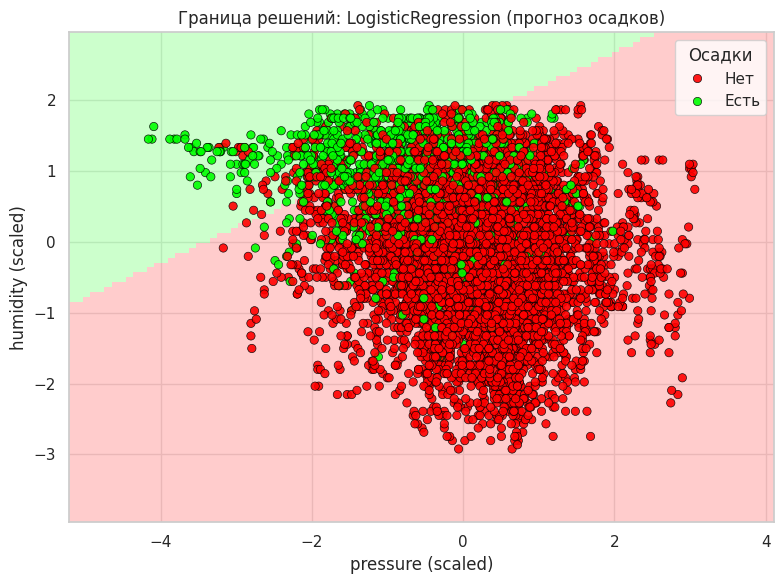

Построение границы решений для SVC...


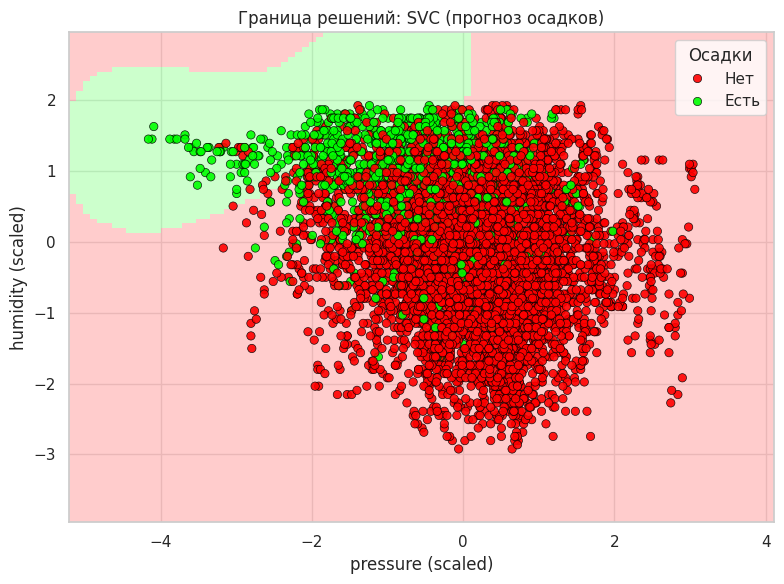

Построение границы решений для RandomForest...


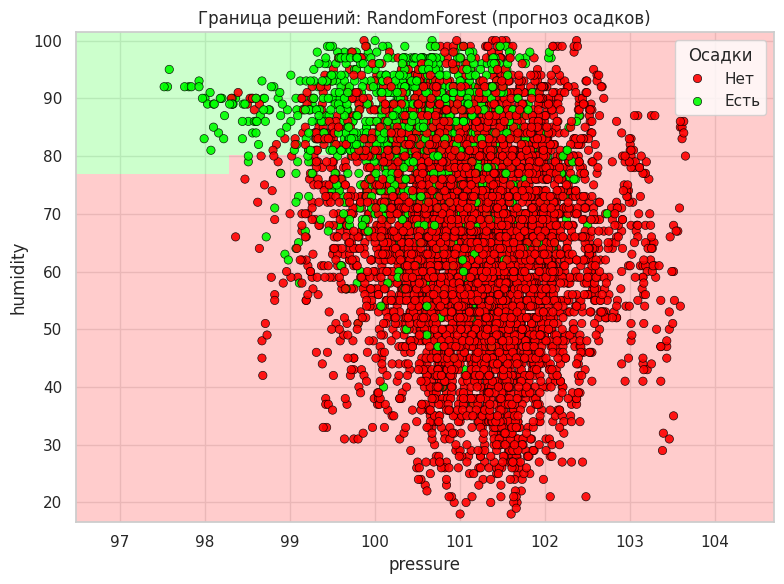

Построение границы решений для XGBoost...


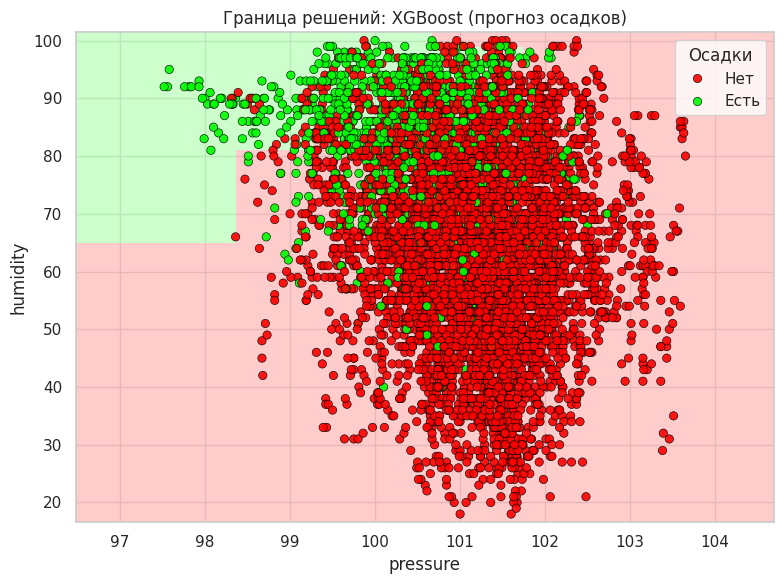

In [43]:
# 10. ГРАНИЦЫ РЕШЕНИЙ (2D) 

from matplotlib.colors import ListedColormap

# Выберем два ключевых признака
feature_pair = ['pressure', 'humidity']
X_2d = X[feature_pair].copy()
y_2d = y.copy()

# Разделение
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(
    X_2d, y_2d, test_size=0.2, stratify=y_2d, random_state=42)

# Масштабирование (только для моделей, которым это нужно)
scaler_2d = StandardScaler()
X_train_2d_scaled = scaler_2d.fit_transform(X_train_2d)
X_test_2d_scaled = scaler_2d.transform(X_test_2d)

# Модели, которые у тебя уже есть и обучались
models_2d = {
    'LogisticRegression': LogisticRegression(C=1, solver='liblinear', random_state=42),
    'SVC': SVC(kernel='rbf', C=1, probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA"])  # Светлые фоны: нет / есть осадки
cmap_bold = ["#FF0000", "#00FF00"]  # Красный = нет, зелёный = есть

# Определи палитру как СЛОВАРЬ
palette_dict = {0: "#FF0000", 1: "#00FF00"}  # 0 → красный, 1 → зелёный

for name, model in models_2d.items():
    print(f"Построение границы решений для {name}...")
    
    if name in ['LogisticRegression', 'SVC']:
        model.fit(X_train_2d_scaled, y_train_2d)
        X_plot = X_train_2d_scaled
        x_label, y_label = f"{feature_pair[0]} (scaled)", f"{feature_pair[1]} (scaled)"
    else:
        model.fit(X_train_2d, y_train_2d)
        X_plot = X_train_2d.values
        x_label, y_label = feature_pair[0], feature_pair[1]

    fig, ax = plt.subplots(figsize=(8, 6))
    
    DecisionBoundaryDisplay.from_estimator(
        model,
        X_plot,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=x_label,
        ylabel=y_label,
        shading="auto",
        alpha=0.6
    )


    scatter = sns.scatterplot(
        x=X_plot[:, 0],
        y=X_plot[:, 1],
        hue=y_train_2d,
        palette=palette_dict,
        alpha=0.9,
        edgecolor="black",
        ax=ax,
        legend='full'  # ← явно включаем легенду
    )
    
    plt.title(f"Граница решений: {name} (прогноз осадков)")
    
    # Изменяем подписи в легенде, НЕ пересоздавая её вручную
    handles, labels = ax.get_legend_handles_labels()
    # Заменяем автоматические метки (0, 1) на понятные
    new_labels = ["Нет", "Есть"]
    ax.legend(handles=handles, labels=new_labels, title="Осадки")
    
    plt.tight_layout()
    plt.show()



In [33]:
# ЗАКЛЮЧЕНИЕ

print("""
Наиболее интересные зависимости:
1. Осадки сильно связаны с высокой влажностью (>70%) и низким давлением (<101.0 кПа).
2. Температура при осадках чаще всего находится в диапазоне 10–20°C.
3. Влажность и точка росы — ключевые признаки для прогноза осадков.
4. Балансировка классов (SMOTE) улучшает AUC у линейных моделей (LogisticRegression, SVC), 
   но деревья (RandomForest, XGBoost) показывают стабильное качество и без неё.
5. Random Forest и XGBoost — наиболее устойчивые и точные модели для данной задачи.
""")

# ВЫВОД ПО МОДЕЛЯМ 
print("""
Анализ качества моделей показал, что ансамбли на основе деревьев решений 
демонстрируют превосходную предсказательную способность и устойчивость:

- **Random Forest** достиг AUC = 0.9873 (±0.0015) на кросс-валидации по сбалансированным данным, 
  что является наивысшим результатом среди всех протестированных моделей. 
  Низкое стандартное отклонение указывает на высокую стабильность модели 
  при изменении обучающей выборки.

- **XGBoost** также показал выдающийся результат (AUC = 0.9856), значительно улучшившись 
  после балансировки классов — это говорит о его чувствительности к дисбалансу, 
  но при этом он остаётся одной из самых мощных моделей.

- **Линейные модели** (Logistic Regression, SVC) продемонстрировали умеренное качество 
  (AUC ≈ 0.92–0.94), что объясняется их inability улавливать сложные нелинейные зависимости 
  между метеорологическими признаками. Балансировка данных дала небольшой прирост, 
  но не позволила приблизиться к качеству ансамблей.

Учитывая высокую точность, интерпретируемость (через важность признаков) 
и устойчивость к выбросам и дисбалансу, **Random Forest рекомендуется в качестве финальной модели** 
для прогнозирования осадков на основе текущих погодных условий.
""")

best_model = max([(name, res['bal'][2]) for name, res in results.items()], key=lambda x: x[1])
print(f"\nЛучшая модель по AUC на сбалансированных данных: {best_model[0]} (AUC = {best_model[1]:.4f})")


Наиболее интересные зависимости:
1. Осадки сильно связаны с высокой влажностью (>70%) и низким давлением (<101.0 кПа).
2. Температура при осадках чаще всего находится в диапазоне 10–20°C.
3. Влажность и точка росы — ключевые признаки для прогноза осадков.
4. Балансировка классов (SMOTE) улучшает AUC у линейных моделей (LogisticRegression, SVC), 
   но деревья (RandomForest, XGBoost) показывают стабильное качество и без неё.
5. Random Forest и XGBoost — наиболее устойчивые и точные модели для данной задачи.


Анализ качества моделей показал, что ансамбли на основе деревьев решений 
демонстрируют превосходную предсказательную способность и устойчивость:

- **Random Forest** достиг AUC = 0.9873 (±0.0015) на кросс-валидации по сбалансированным данным, 
  что является наивысшим результатом среди всех протестированных моделей. 
  Низкое стандартное отклонение указывает на высокую стабильность модели 
  при изменении обучающей выборки.

- **XGBoost** также показал выдающийся результат (AUC =